**please execute this script in Python 3.x**

**Introduction:**

This notebook contains an attempt to forecast the delivery times on a prediction data set. 
A multi-linear regression model is trained on a training data set and the model applied to the prediction data set. 
The features in the data set are given as grouped into three main categories. They are added step-by-step to the model if they are found to improve the model performance metrics.

**Overview:**

This script is organized into 8 sections as follows:
- Section 1: setup
- Section 2: data inspection and initial cleaning
- Section 3: feature exploration
- Section 4: run model on initial feature selection
- Section 5: add features from another category
- Section 6: add features from another category
- Section 7: add features from another category
- Section 8: apply fitted model to prediction data set

**Results:**

One way to estimate delivery times is to build a multi-linear regression model which incorporates information about multiple features. The following summarizes the output from a multilinear regression model trained on selected features from the historical data set provided. We are aiming to predict the dependent variable (the total delivery duration time in seconds between the order creation and arrival to the customer) based on a set of historical features related to the time requirements, store attributes, order characteristics, market features, and complementary predictive model outputs.
Multilinear regression is a powerful tool for finding key features driving a response and assigning weights to them so they can be combined to make predictions using new input data. The model itself has a few assumptions, the first and biggest being that there is a linear relationship between outcome and the independent variables or features included in the model. It also requires that residuals are normally distributed. In general these will not be met if we have extreme outliers. While there are some ways to account for outliers in a robust model when it’s necessary to be able to predict extreme values, here they are discarded in favor of a better model fit and greater predictive power.
Below we see the total delivery duration and can visually identify extreme outliers with delivery times on the order of days.
These are considered outliers and removed from the training data set. The distribution of the remaining data (below) resembles a Poisson distribution, which is not atypical for a distribution of random 'arrival times'.


The feature data in the training (historical) dataset is further cleansed by removing rows with missing values. Overall, roughly 88% (or around 170,000 rows) of the data in the training set is preserved.
Since the model includes many types of variables (continuous, categorical, rank order, timestamp) and over varying scales (100s to 1000s for cost in cents, 10s to 100s for onshift drivers), it is important to first transform and scale the data. This allows each feature an equal opportunity for inclusion in the final model instead of favoring the features with the largest values. Once the variables are transformed and scaled, each is added individually to the regression model. If the model fit improves, the variable remains within the model and if not, it is removed.
The most predictive power resulted from a model including the independent variables estimated_order_place_duration, estimated_store_to_consumer_driving_duration, total_available_drivers, total_outstanding_orders, market_id. The model has a mean absolute error of 705 seconds or about 12 minutes, which is about 25% of the average delivery time (~45 minutes). The adjusted R-squared value is 0.17. The distribution of the predicted duration times is shown in the figure below. The predicted durations are less skewed than the historical durations.



# Section 1: setup

1.1 mount the google drive to import the data

1.2 import packages and models needed for the analysis

1.3 setup class whose methods will be used for the analysis throughout 

1.4 load the two data sets into two 'FrameWork' objects

In [1]:
# 1.1
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# 1.2
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing

In [0]:
# 1.3
# setup class 'FrameWork' with methods to be used throughout this script

class FrameWork(object):
  """ general framework class whose methods will be used throughout the analysis

  """

  def __init__(self):
    """ store raw data, cleaned data, model and feature scaler within FrameWork

    """

    self._raw_data = None
    self._data = None  # cleaned and preprocessed data
    self._model = None  # model
    self._scaler = None  # feature scaler

  @property
  def raw_data(self)-> pd.DataFrame:
    """ getter for raw data

    """

    return self._raw_data

  @raw_data.setter
  def raw_data(self, data_path: str) -> None:
    """ setter for raw data
    
    """

    self._raw_data = pd.read_csv(data_path)
    print('data loaded successfully')

    return None

  @property
  def data(self)-> pd.DataFrame:
    """ getter for cleaned data

    """

    return self._data

  def update_data(self, input_data: pd.DataFrame) -> None:
    """ overwrite cleaned data

    """

    self._data = input_data

    return None

  def clean_data(self, drop_nans_flag: bool=False) -> None:
    """ clean raw data

    if the drop_nans_flag is set to True, a copy of the loaded raw data will 
    be made and all rows containing any NaN values removed

    """

    self._data = copy.deepcopy(self._raw_data)

    if drop_nans_flag:
      self._data = self._data.dropna()

    print('Number of rows: raw data ', self._raw_data.shape[0])
    print('Number of rows: cleaned data ', self._data.shape[0])

    return None

  def get_scaler(self):
    """ return the feature scaler

    """

    return self._scaler

  def get_model(self):
    """ return the model

    """

    return self._model

  def initialize_model(self) -> None:
    """ initialize the model

    choose multilinear regression model

    """

    self._model = LinearRegression()

    return None

  def initialize_scaler(self) -> None:
    """ initialize feature scaler

    """

    self._scaler = preprocessing.StandardScaler()

    return None

  def get_model_performance_metrics(self, y_test: pd.DataFrame, y_prediction: 
                                    pd.DataFrame, 
                                    x: pd.DataFrame)-> (float, float, float):
    """ define model performance metrics and return them

    """

    # mean absolute error
    MAE = metrics.mean_absolute_error(y_test, y_prediction)  
    #R^2 value
    R2 = self._model.score(x, y_test)
    # adjusted R^2 value
    R2_adj =  1 - (1-self._model.score(x, y_test))*(len(y_test) - 1)/ \
             (len(y_test) - x.shape[1]-1)
    
    return MAE, R2, R2_adj

  def evaluate_model(self, selected_features: str, target: str
                     , scale_features_flag: bool=True)-> None:
    """ fit, evaluate model and return performance metrics for given 
        feature selection

    """

    # initialize model
    self.initialize_model()

    # temporary copy of data
    df = copy.deepcopy(self.data) 

    if scale_features_flag:
      self.initialize_scaler()  # initialize scaler
      self._scaler.fit(df[selected_features])  # scale data
      df[selected_features ]= self._scaler.transform(df[selected_features])

    X = df[selected_features]
    y = df[target]
    kf = KFold(n_splits=10)  # choose 10-fold splits
    kf.get_n_splits(X)

    # initialize outputs metrics
    MAE = []
    R2 = []
    R2_adj = []
    
    # run model over k-fold splits and append performance metrics
    for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      self._model.fit(X_train, y_train)
      y_prediction = self._model.predict(X_test)
      MAE_, R2_, R2_adj_ = self.get_model_performance_metrics(y_test, 
                                                      y_prediction, X_test)
      MAE.append(MAE_)
      R2.append(R2_)
      R2_adj.append(R2_adj_)

    print('average mean absolute error: ', round(sum(MAE)/len(MAE), ndigits=2))
    print('R-squared value: ', round(sum(R2)/len(R2), ndigits=4))
    print('Adjusted R-squared value: ', round(sum(R2_adj)/len(R2_adj), ndigits=4))


    return None

  def check_dropped_data(self)-> float:
    """ return percentage amount of cleaned to raw data

    """
    
    print('number of rows in raw data set: ', self._data.shape[0])
    data_percentage_dropped_rows = (1 - self._data.shape[0]/
                                    self._raw_data.shape[0]) * 100

    return data_percentage_dropped_rows


**Load Data**

data is saved on a google drive that is mounted at the beginning of this script


In [34]:
# 1.4
# initialize frameworks for training and predition data sets
training_fw = FrameWork()
predict_fw = FrameWork()

# load data
path = '/content/drive/My Drive/DeliveryTimeForecasting/'

training_fw.raw_data = path + 'historical_data.csv'
predict_fw.raw_data = path + 'predict_data.csv'

data loaded successfully
data loaded successfully


# Section 2: data inspection and initial cleaning

2.1 data type inspection

2.2 initial data cleaning

2.3 initial data preprocessing

**2.1 Inspect raw data**

In [35]:
# 2.1
# check types in each column
frameworks = [training_fw, predict_fw]
for fw in frameworks:
  types_by_column = {}
  for col in fw.raw_data.columns:
    types_by_column[col] = fw.raw_data[col].dtype

  print(types_by_column)


{'Unnamed: 0': dtype('int64'), 'market_id': dtype('float64'), 'created_at': dtype('O'), 'actual_delivery_time': dtype('O'), 'store_id': dtype('int64'), 'store_primary_category': dtype('O'), 'order_protocol': dtype('float64'), 'total_items': dtype('int64'), 'subtotal': dtype('int64'), 'num_distinct_items': dtype('int64'), 'min_item_price': dtype('int64'), 'max_item_price': dtype('int64'), 'total_onshift_drivers': dtype('float64'), 'total_busy_drivers': dtype('float64'), 'total_outstanding_orders': dtype('float64'), 'estimated_order_place_duration': dtype('int64'), 'estimated_store_to_consumer_driving_duration': dtype('float64')}
{'Unnamed: 0': dtype('int64'), 'market_id': dtype('float64'), 'created_at': dtype('O'), 'store_id': dtype('int64'), 'store_primary_category': dtype('O'), 'order_protocol': dtype('float64'), 'total_items': dtype('int64'), 'subtotal': dtype('int64'), 'num_distinct_items': dtype('int64'), 'min_item_price': dtype('int64'), 'max_item_price': dtype('int64'), 'total_on

**2.2 data cleaning**

training data:
- drop all rows that contain any nan values

prediction data:
- initialize clean data = raw data

In [36]:
print('training data: ')
training_fw.clean_data(drop_nans_flag=True)

# check that all nans are indeed dropped
print('nans dropped? ', training_fw.data.isnull().sum().sum()==0)

# check percentage dropped data
print('percentage dropped data so far: ', training_fw.check_dropped_data())
# 11 percent of the initial data dropped; 175k rows remaining

print('prediction data: ')
predict_fw.clean_data()  # initializes the clean data in the prediction framework

training data: 
Number of rows: raw data  197428
Number of rows: cleaned data  175777
nans dropped?  True
number of rows in raw data set:  175777
percentage dropped data so far:  10.96652957027372
prediction data: 
Number of rows: raw data  54778
Number of rows: cleaned data  54778


**2.3 preprocess data**

training data only:

feature formatting
- get the difference between the actual delivery time and the time the order was created in seconds
- add these values to the clean data in separate column with label 'total_duration'

data quality
- only keep rows where total time duration is positive
- visual inspection of data: check for unreasonable values and remove




In [0]:
# feature formatting
df_created_at = pd.to_datetime(training_fw.data['created_at'])
df_actual_delivery_time = pd.to_datetime(training_fw.data['actual_delivery_time'])
total_duration_vals = (df_actual_delivery_time.values - 
                       df_created_at.values) / np.timedelta64(1, 's')
dict_ = dict(training_fw.data)  # put dataframe into dictionary
dict_['total_duration'] = total_duration_vals  # create new key with values
df_tmp = pd.DataFrame(dict_)  # temporary datafram with new column and values
training_fw.update_data(df_tmp)  # update data in training framework

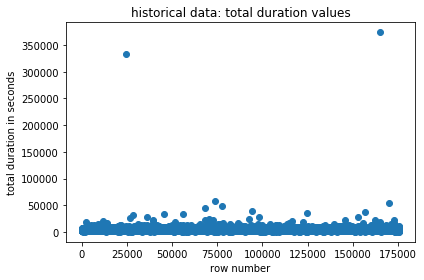

In [38]:
# data quality 
# remove rows that have negative total duration from training data set
condition = (training_fw.data['total_duration'] > 0)
training_fw.update_data(training_fw.data[condition])

# inspect total duration data
y = training_fw.data['total_duration']
x = range(len(y))
plt.scatter(x, y)
plt.xlabel('row number')
plt.ylabel('total duration in seconds')
plt.title('historical data: total duration values')
plt.tight_layout()
plt.savefig(path + 'total_duration_input_data.jpg', dpi=200)
plt.show()

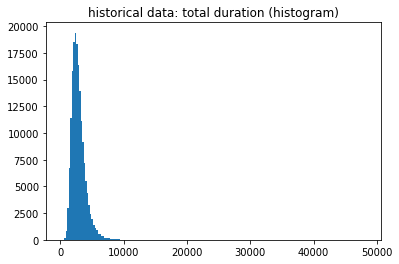

In [39]:
""" observation: there are data points with total duration > 300.000s ~ 80h

consider these as unreasonable and remove any values < 50000 (14h) from data set
and inspect distribution in histogram
"""

condition = (training_fw.data['total_duration'] < 50000)
training_fw.update_data(training_fw.data[condition])

# plot histogram of cropped training data set
y = training_fw.data['total_duration']
plt.hist(y, bins=200)
plt.title('historical data: total duration (histogram)')
plt.show()

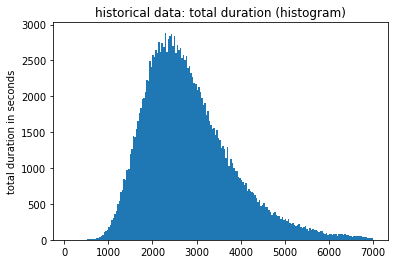

In [40]:
""" observations: total duration values above 7000s (~2h) seem to be rare events

consider those as outliers and remove from data set and re-evaluate histogram
"""

condition = (training_fw.data['total_duration'] < 7000)
training_fw.update_data(training_fw.data[condition])

y = training_fw.data['total_duration']
plt.hist(y, bins=200)
plt.title('historical data: total duration (histogram)')
plt.ylabel('total duration in seconds')
plt.savefig(path + 'total_duration_cleaned_histogram.jpg', dpi=200)
plt.show()

# distribution looks like a Poisson distribution

In [41]:
# inspect values for short durations

print(sorted(training_fw.data['total_duration'])[0:10])

""" observations

a few very short total delivery times are found in the data set; 3 data points 
with less than 5 minutes delivery time. The shortest delivery time is ~2 min 
which is not unrealistic
"""

[101.0, 223.0, 297.0, 321.0, 325.0, 352.0, 386.0, 386.0, 406.0, 429.0]


' observations\n\na few very short total delivery times are found in the data set; 3 data points \nwith less than 5 minutes delivery time. The shortest delivery time is ~2 min \nwhich is not unrealistic\n'

# Section 3: feature exploration

3.1 data exploration: correlation analysis of features with predictor variable



**3.1 correlation analysis**

- for each feature in the training data set, get absolute value of the correlation between the feature and the total duration time

In [42]:
# discriminate between numerical and cagetorical features

features_numerical = ['total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_drivers', 'total_busy_drivers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration']

features_categorical = ['market_id', 'store_id',
       'store_primary_category', 'order_protocol']

target_feature = ['total_duration']
df_tmp = copy.deepcopy(training_fw.data)

dict_numerical = {}  # initialize results dictionary
for feature in features_numerical:
  cols = target_feature + list([feature])
  df = df_tmp[cols]
  corr_coeff_mx = df.corr(method='spearman')  # get correlation coefficient 
  abs_corr_coeff = np.abs(np.array(corr_coeff_mx)[0][1])
  dict_numerical[feature] = abs_corr_coeff

dict_numerical


{'estimated_order_place_duration': 0.10456842061788515,
 'estimated_store_to_consumer_driving_duration': 0.26705865194083644,
 'max_item_price': 0.16340549602300927,
 'min_item_price': 0.0007622948816507189,
 'num_distinct_items': 0.16574158597230176,
 'subtotal': 0.23878378897154975,
 'total_busy_drivers': 0.11096333015671529,
 'total_items': 0.15900151934460477,
 'total_onshift_drivers': 0.08682014603252831,
 'total_outstanding_orders': 0.18479953497291984}

In [43]:
"""
observation: estimated store to consumer driving duration has the largest 
correlation coefficient with the total duration, followed by the subtotal

"""

# analysis for categorical features
dict_categorical = {}
for feature in features_categorical:
  if feature == 'store_id':
    print('skip store_id as there are many for the encoder to respond in a \
    reasonable time')
  else:
    print(feature)
    df_tmp = copy.deepcopy(training_fw.data)
    # encode categorical variable; use pandas dummy encoder
    df_dummies = pd.get_dummies(df_tmp[feature])
    del df_dummies[df_dummies.columns[-1]]
    df_tmp = pd.concat([df_tmp, df_dummies], axis=1)
    del df_tmp[feature]

    for new_feature in df_dummies.columns:
      cols = target_feature + list([new_feature])
      df = df_tmp[cols]
      df = df.dropna()  # drop NaN values
      corr_coeff_mx = df.corr(method='spearman')
      abs_corr_coeff = np.abs(np.array(corr_coeff_mx)[0][1])
      dict_categorical[feature] = abs_corr_coeff

dict_categorical

market_id
skip store_id as there are many for the encoder to respond in a     reasonable time
store_primary_category
order_protocol


{'market_id': 0.017713773586384506,
 'order_protocol': 0.04234224519328873,
 'store_primary_category': 0.0016742455507339985}

In [44]:
"""
observation: out of the categorical variables, the order protocol has the largest
correlation with the total duration

"""

dict_numerical.update(dict_categorical)
print('absolute correlation coefficients between features and total duration')
dict_numerical  # print all correlation coefficients

absolute correlation coefficients between features and total duration


{'estimated_order_place_duration': 0.10456842061788515,
 'estimated_store_to_consumer_driving_duration': 0.26705865194083644,
 'market_id': 0.017713773586384506,
 'max_item_price': 0.16340549602300927,
 'min_item_price': 0.0007622948816507189,
 'num_distinct_items': 0.16574158597230176,
 'order_protocol': 0.04234224519328873,
 'store_primary_category': 0.0016742455507339985,
 'subtotal': 0.23878378897154975,
 'total_busy_drivers': 0.11096333015671529,
 'total_items': 0.15900151934460477,
 'total_onshift_drivers': 0.08682014603252831,
 'total_outstanding_orders': 0.18479953497291984}

data quality

- visual inspection for outliers and anomalies in order place duration and estimated store to consumer duration

# Section 4: run model on initial features selection

4.1 inpect the first selected features' data 

4.2 clean data if necessary

4.3 train, predict and evaluate model

**4.1 data inspection**

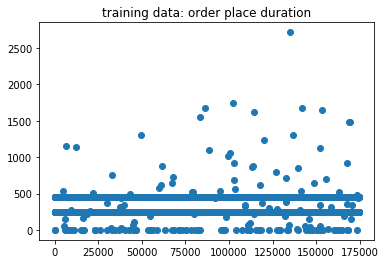

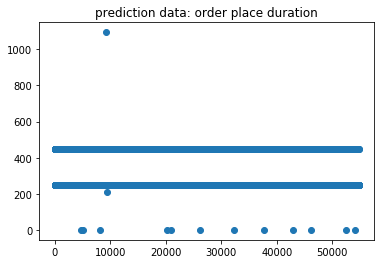

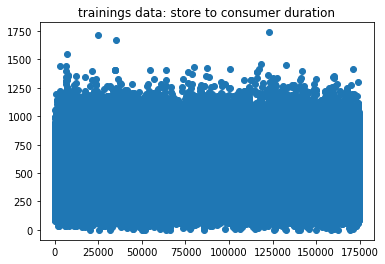

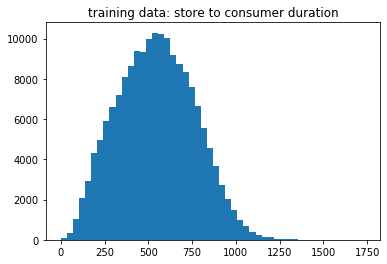

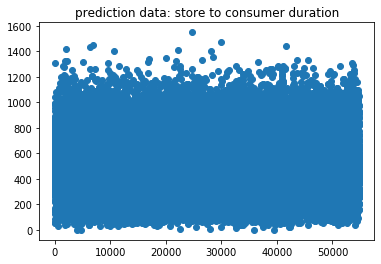

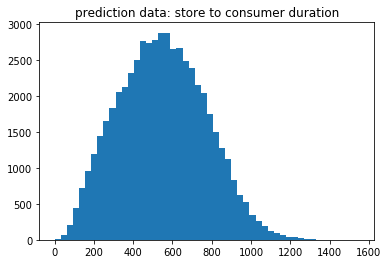

In [45]:
4.1
# inspect estimated order place duration in both historical as well as prediction 
# data set
y = training_fw.data['estimated_order_place_duration'].values
x = range(len(y))
plt.scatter(x, y)
plt.title('training data: order place duration')
plt.show()
plt.close()

y = predict_fw.data['estimated_order_place_duration'].values
x = range(len(y))
plt.scatter(x, y)
plt.title('prediction data: order place duration')
plt.show()
plt.close()

y = training_fw.data['estimated_store_to_consumer_driving_duration'].values
x = range(len(y))
plt.scatter(x, y)
plt.title('trainings data: store to consumer duration')
plt.show()
plt.close()
plt.hist(y, bins=50)
plt.title('training data: store to consumer duration')
plt.show()
plt.close()

y = predict_fw.data['estimated_store_to_consumer_driving_duration'].values
x = range(len(y))
plt.scatter(x, y)
plt.title('prediction data: store to consumer duration')
plt.show()
plt.close()
plt.hist(y[~np.isnan(y)], bins=50)
plt.title('prediction data: store to consumer duration')
plt.show()
plt.close()

**4.2 data cleaning**

In [46]:
""" observation: both data sets have some negative values for both estimated
driving duration as well as order place duration

consider these unreasonable and remove from data sets

"""


for fw in frameworks:
  condition = (fw.data['estimated_order_place_duration'] > 0) & \
  (fw.data['estimated_store_to_consumer_driving_duration'] > 0)
  fw.update_data(fw.data[condition])

# check what percentage of data has been dropped so far
print('percentage data dropped from training set'
, training_fw.check_dropped_data())

print('percentage data dropped from prediction set'
, predict_fw.check_dropped_data())

# consider remaining data still sufficient for 

number of rows in raw data set:  174562
percentage data dropped from training set 11.581943797232409
number of rows in raw data set:  54753
percentage data dropped from prediction set 0.045638760086164076


**4.3: Train, Predict and Evaluate**

initial selection of features
- choose estimated order place duration and estimated store to consumer duration as independent variables
- fit model and get performance metrics


In the first stage, only include features from 
estimation model into analysis

In [48]:
# select features to include in model fitting

# start with features from estimation model only
selected_features = ['estimated_order_place_duration', 
                     'estimated_store_to_consumer_driving_duration']

target = ['total_duration']

# evaluate model
training_fw.evaluate_model(selected_features=selected_features, target=target)

average mean absolute error:  751.37
R-squared value:  0.0733
Adjusted R-squared value:  0.0732


# Section 5: add features

5.1 inspect data for 'market' features

5.2 clean data: replace missing data, remove outliers and anomalies

5.3 train, predict and evaluate model

**5.1 Add 'market' features**

- inspect data for these features in both training data as well as prediction data set
- if necessary, clean training data and preprocess prediction data

In [49]:
# check in training and predition data set whether there are data points with 
# values for total_busy_drivers and total_onshift_drivers smaller than zero

features = ['total_busy_drivers', 'total_onshift_drivers']
for feature in features:
  for i, fw in enumerate(frameworks):
    condition = (fw.data[feature] < 0)
    if i==0: 
      print('training data')
    else: 
      print('predition data')
    print('Number of data points where feature ' + str(feature) + 
          ' value less than zero:' , fw.data[feature][condition].shape[0])
    print('distinct values are: ', set(fw.data[feature][condition]))


"""
observation: both data sets have values for number of drivers < 0

for prediction data set: take mean value of the two neighboring data points
for training data set: delete rows that fulfil this condition

"""

training data
Number of data points where feature total_busy_drivers value less than zero: 21
distinct values are:  {-2.0, -5.0, -4.0, -3.0, -1.0}
predition data
Number of data points where feature total_busy_drivers value less than zero: 10
distinct values are:  {-4.0, -3.0, -1.0, -2.0}
training data
Number of data points where feature total_onshift_drivers value less than zero: 21
distinct values are:  {-4.0, -3.0, -2.0, -1.0}
predition data
Number of data points where feature total_onshift_drivers value less than zero: 2
distinct values are:  {-1.0}


'\nobservation: both data sets have values for number of drivers < 0\n\nfor prediction data set: take mean value of the two neighboring data points\nfor training data set: delete rows that fulfil this condition\n\n'

**5.2 clean data**

- replace NaN values in prediction data
- remove unreasonable values in training data

In [50]:
# prediction data: replace negative values for above two features first with
# NaN values and then all NaN values with mean value of neighboring two values

for feature in features:
  condition = (predict_fw.data[feature] < 0)
  df_tmp = copy.deepcopy(predict_fw.data)

  # replace vals with NaNs
  if feature == 'total_busy_drivers':
    # manually setup dictionary; could be automized
    dict_replacements = {-4.0: np.NaN, -3.0: np.NaN, -2.0: np.NaN, 
                         -1.0: np.NaN}  
    df_tmp.total_busy_drivers = \
      df_tmp.total_busy_drivers.replace(dict_replacements)

  if feature == 'total_onshift_drivers':
    # manually setup dictionary; could be automized
    dict_replacements = {-1.0: np.NaN} 
    df_tmp.total_onshift_drivers = \
     df_tmp.total_onshift_drivers.replace(dict_replacements)

  predict_fw.update_data(df_tmp)

  # fill all NaNs with mean of neighboring data points
  vals_tmp = predict_fw.data[feature]
  vals_tmp = (vals_tmp.ffill() + vals_tmp.bfill())/2
  print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

  # put cleaned data into framework data
  dict_ = dict(predict_fw.data)
  dict_[feature] = vals_tmp
  df_tmp = pd.DataFrame(dict_)
  predict_fw.update_data(df_tmp)

# check amount of data dropped
print('percentage data dropped from prediction set'
, predict_fw.check_dropped_data())

# available data still considered sufficiently big enough

Are all NaNs overridden?  True
Are all NaNs overridden?  True
number of rows in raw data set:  54753
percentage data dropped from prediction set 0.045638760086164076


In [51]:
# training data: only consider data where the number of total onshift and 
# busy drivers is greater or equal to zero

for feature in features:
  condition = (training_fw.data[feature] >= 0)
  training_fw.update_data(training_fw.data[condition])

# check amount of data dropped
print('percentage data dropped from prediction set'
, training_fw.check_dropped_data())

# available data considered sufficiently big enough

number of rows in raw data set:  174521
percentage data dropped from prediction set 11.60271086168122


inspect data for this feature

total_busy_drivers


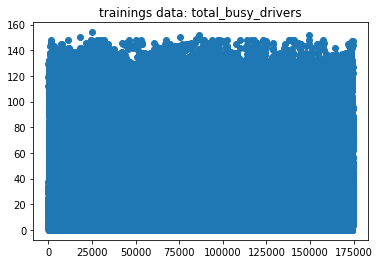

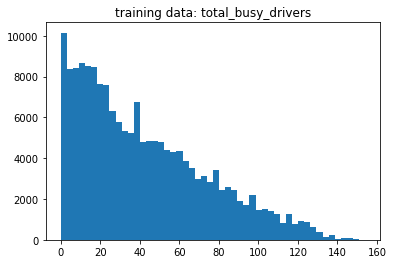

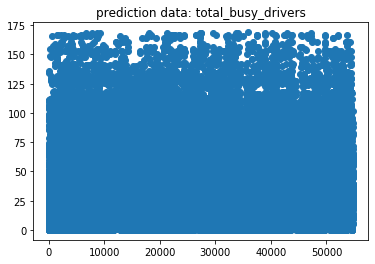

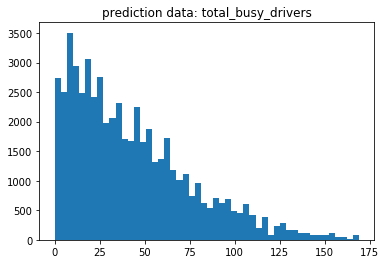

total_onshift_drivers


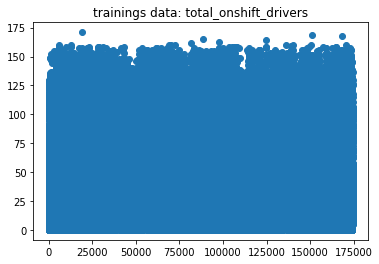

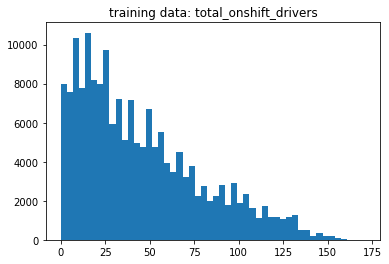

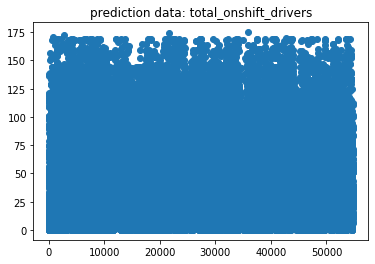

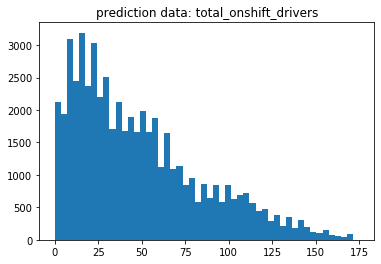

In [52]:
# visual inspection of total onshift and busy drivers for anomalies in both
# data sets

for feature in features:
  print(feature)
  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y)
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.title('training data: ' + feature)
  plt.show()
  plt.close()

  y = predict_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y)
  plt.title('prediction data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y[~np.isnan(y)], bins=50)
  plt.title('prediction data: ' + feature)
  plt.show()
  plt.close()

In [53]:
for feature in features:
  condition = (predict_fw.data[feature] < 0)
  df_tmp = copy.deepcopy(predict_fw.data)

  # replace vals with NaNs
  if feature == 'total_busy_drivers':
    dict_replacements = {-4.0: np.NaN, -3.0: np.NaN, -2.0: np.NaN, 
                         -1.0: np.NaN}
    df_tmp.total_busy_drivers = \
      df_tmp.total_busy_drivers.replace(dict_replacements)

  if feature == 'total_onshift_drivers':
    dict_replacements = {-1.0: np.NaN}
    df_tmp.total_onshift_drivers = \
     df_tmp.total_onshift_drivers.replace(dict_replacements)

  predict_fw.update_data(df_tmp)

  # fill all NaNs with mean of neighboring data points
  vals_tmp = predict_fw.data[feature]
  vals_tmp = (vals_tmp.ffill() + vals_tmp.bfill())/2
  print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

  # put cleaned data into framework data
  dict_ = dict(predict_fw.data)
  dict_[feature] = vals_tmp
  df_tmp = pd.DataFrame(dict_)
  predict_fw.update_data(df_tmp)



Are all NaNs overridden?  True
Are all NaNs overridden?  True


In [0]:
"""
observations: no visual outliers or anomalies in above plots

"""

# take difference between total number of busy and onshift drivers to get total 
# number of available drivers
# label this new feature 'total_available_drivers' and add this to both data sets

for fw in frameworks:
  total_available_drivers = fw.data['total_onshift_drivers'] \
                            - fw.data['total_busy_drivers']
  dict_ = dict(fw.data)
  dict_['total_available_drivers'] = total_available_drivers
  df_tmp = pd.DataFrame(dict_)
  fw.update_data(df_tmp)

**5.3 Evaluate model with added feature**

In [56]:
# evaluate model with added feature 'total_available_drivers'

selected_features.append('total_available_drivers')
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)

current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers']
average mean absolute error:  750.72
R-squared value:  0.0751
Adjusted R-squared value:  0.0749


# Section 6: add features

6.1 analyze additional feature

6.2 preprocess data: check availability of categorical feature in both training as well as prediction data set

6.3 clean data

6.4 train, predict and evaluate model


**6.1 Add feature to analysis**

total_outstanding_orders


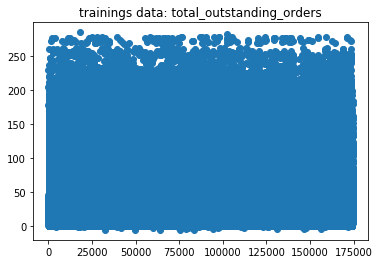

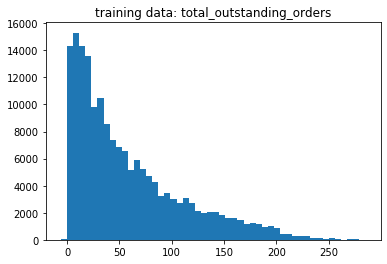

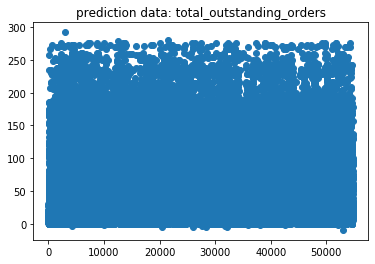

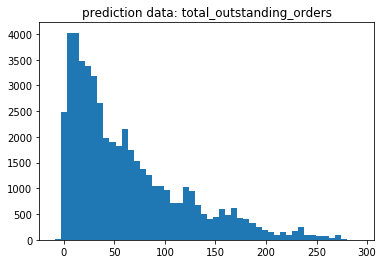

In [57]:
"""
observation: adjusted R-squared value still around 0.7

inspect data for 'total_outstanding_orders', clean and preprocess, 
add to selected features and re-evaluate model
"""

# visual inspection of total outstanding orders for anomalies in both data sets
features = ['total_outstanding_orders']
for feature in features:
  print(feature)
  y = training_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y)
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.title('training data: ' + feature)
  plt.show()
  plt.close()

  y = predict_fw.data[feature].values
  x = range(len(y))
  plt.scatter(x, y)
  plt.title('prediction data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y[~np.isnan(y)], bins=50)
  plt.title('prediction data: ' + feature)
  plt.show()
  plt.close()


6.2 data quality inspection

In [58]:
# check in training and predition data set whether there are data points with 
# values for total outstanding orders that are smaller than zero

for feature in features:
  for i, fw in enumerate(frameworks):
    condition = (fw.data[feature] < 0)
    if i==0: 
      print('training data')
    else: 
      print('predition data')
    print('Number of data points where feature ' + str(feature) + 
          ' value less than zero:' , fw.data[feature][condition].shape[0])
    print('distinct values are: ', set(fw.data[feature][condition]))


"""
observation: both data sets have values for total outstanding orders < 0

for prediction data set: replace negative values with zero
for training data set: delete rows that fulfil this condition

"""

training data
Number of data points where feature total_outstanding_orders value less than zero: 37
distinct values are:  {-1.0, -6.0, -5.0, -4.0, -3.0, -2.0}
predition data
Number of data points where feature total_outstanding_orders value less than zero: 13
distinct values are:  {-2.0, -9.0, -5.0, -4.0, -3.0, -1.0}


'\nobservation: both data sets have values for total outstanding orders < 0\n\nfor prediction data set: replace negative values with zero\nfor training data set: delete rows that fulfil this condition\n\n'

6.3 data cleaning

In [59]:
# prediction data set: replace negative values for feature with zeros and replace
# NaN values with mean values

df_tmp = copy.deepcopy(predict_fw.data)

# replace vals with zeros
dict_replacements = {-9.0: 0, -5.0: 0, -4.0: 0, -3.0: 0, -2.0: 0, -1.0: 0}
df_tmp.total_outstanding_orders = \
    df_tmp.total_outstanding_orders.replace(dict_replacements)

# update framework
predict_fw.update_data(df_tmp)

feature = 'total_outstanding_orders'
# check if there are NaNs:
print('NaN values in data for total outstanding order? ',
      df_tmp[feature].isnull().sum() != 0)

# fill NaN values with mean values
vals_tmp = df_tmp[feature].fillna(df_tmp[feature].mean())
print('Are all NaNs overridden? ', vals_tmp.isnull().sum() == 0)

# put cleaned data into framework data
dict_ = dict(df_tmp)
dict_[feature] = vals_tmp
df_tmp = pd.DataFrame(dict_)
predict_fw.update_data(df_tmp)


NaN values in data for total outstanding order?  True
Are all NaNs overridden?  True


In [60]:
# training data set: only consider data that has values greater than zero
# for this feature 

condition = (training_fw.data[feature] >= 0)
training_fw.update_data(training_fw.data[condition])

# check amount of data dropped
print('percentage data dropped from prediction set'
, training_fw.check_dropped_data())

# amount of data still considered sufficient


# To check results: rerun above analysis on negative values

number of rows in raw data set:  174484
percentage data dropped from prediction set 11.621451871061861


6.4 evaluate model with added feature

In [61]:
# evaluate model with added feature 'total_outstanding_orders'

selected_features.append('total_outstanding_orders')
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)

current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers', 'total_outstanding_orders']
average mean absolute error:  721.46
R-squared value:  0.1284
Adjusted R-squared value:  0.1282


# Section 7: add features

7.1 analyze additional feature

7.2 inspect data quality

7.3 clean data

7.4 train, predict and evalute model



7.1 inspect added feature data


In [62]:
"""
observation: Adjusted R-squared value increased from 0.07 to 0.12

try to include more features and see whether the R-squared value inceases

As a next step, include the market_id into the analysis 
This is considered a cagetorical variable, not an ordinal one and will need 
encoding

"""

# check how many distinct market_ids are in both data sets
feature = 'market_id' 

for i, fw in enumerate(frameworks):
  if i==0:
    print('training data set')
  else:
    print('prediction data set')

  print('distinct values are: ', sorted(set(fw.data[feature])))


training data set
distinct values are:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
prediction data set
distinct values are:  [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

7.2 data quality inspection

In [63]:
"""
observation: 
  - training data set has no NaNs, while prediction data set has NaNs
  - all distinct non-NaN values are the same in prediction and training data set

inspect prediction data set further on how many NaNs are there
"""

# number of nans and total number of prediction data set rown
print('NaNs for feature in prediction data set', 
      predict_fw.data[feature].isnull().sum())
print('total number of rows in prediction data set', predict_fw.data.shape[0])


NaNs for feature in prediction data set 250
total number of rows in prediction data set 54753


7.3 data cleaning

In [64]:
"""
observation: total number of NaNs is less than 5% of the total data 

find most common market_id in training and prediction data set 
"""
for i, fw in enumerate(frameworks):
  if i==0:
    print('training data')
  else:
    print('prediction data')

  df_tmp = copy.deepcopy(fw.data)
  print(df_tmp.groupby(feature)['created_at'].nunique())

training data
market_id
1.0    36011
2.0    51972
3.0    20690
4.0    44916
5.0    17023
6.0      634
Name: created_at, dtype: int64
prediction data
market_id
1.0     9662
2.0    15108
3.0     6171
4.0    12862
5.0     5497
6.0     4155
Name: created_at, dtype: int64


In [0]:
"""
observation: most common market_id is 2.0 in both data sets

replace NaN values in prediction data set with 2.0
"""

df_tmp = copy.deepcopy(predict_fw.data)
df_tmp['market_id'].fillna(2.0, inplace=True)

predict_fw.update_data(df_tmp)

# to check that all nans are actually replaced, execute statement above where
# distinct number of values are obtained

In [0]:
# first replace integer values for market_ids with strings using the mapping given 
# in the dictionary below
# then use dummy (one-hot) encoding for the categorical market_id variable and
# apply to both data sets

dict_replacements = {1.0: 'city_1', 2.0: 'city_2', 3.0: 'city_3', 4.0: 'city_4',
                  5.0: 'city_5', 6.0: 'city_6'}
                  
for fw in frameworks:
  df_tmp = copy.deepcopy(fw.data)
  df_tmp.market_id = df_tmp.market_id.replace(dict_replacements)
  dummies = pd.get_dummies(df_tmp.market_id)
  df_tmp = df_tmp.join(dummies)
  fw.update_data(df_tmp)

7.4 evalute model with added feature



In [67]:
# evaluate model with added features 'city_1', ..., 'city_6'
features_market_id = list(dict_replacements.values())
selected_features.extend(features_market_id)
print('current features considered: ', selected_features)

training_fw.evaluate_model(selected_features=selected_features, target=target)


current features considered:  ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'total_available_drivers', 'total_outstanding_orders', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6']
average mean absolute error:  705.28
R-squared value:  0.1664
Adjusted R-squared value:  0.1659


# Section 8: remaining feature and model prediction

8.1 inspect remaining feature

8.2 apply trained model to prediciton data set

8.1 inspect additional features

In [68]:
"""
observation: R-squared value increased to 0.16; MAE dropped

- keep feature in analysis
- add the store features to the analysis
"""

# inspect data in both data sets for the feature 'store_primary_category'

# get distinct restaurant types are in both data sets
training_store_categories = set(training_fw.data['store_primary_category'])
print('store categories in training set: ', training_store_categories)
predict_store_categories = set(predict_fw.data['store_primary_category'])
print('store categories in prediction set: ', predict_store_categories)

# get restaurant types in the prediction set that are not in the training set 
# and vice versa

print('store categories in training set but not in prediction set')
print(list(training_store_categories - predict_store_categories))
print('store categories in prediction set but not in training set')
print(list(predict_store_categories - training_store_categories))


# inspect data in both data sets for the feature 'store_id'

# get distinct restaurant types are in both data sets
training_store_id = set(training_fw.data['store_id'])
print('store IDs in training set: ', training_store_id)
print('number of store IDs in training set:', len(training_store_id))
predict_store_id = set(predict_fw.data['store_id'])
print('store IDs in prediction set: ', predict_store_id)
print('number of store IDs in prediction set:', len(predict_store_id))

# get restaurant types in the prediction set that are not in the training set and
# vice versa

print('store IDs in training set but not in prediction set')
store_ids_not_in_prediction_set = list(training_store_id - predict_store_id)
print(store_ids_not_in_prediction_set)
print('number of store IDs not in prediction set: ', 
      len(store_ids_not_in_prediction_set))

store_ids_not_in_training_set = list(predict_store_id - training_store_id)
print('store IDs in prediction set but not in training set')
print(store_ids_not_in_training_set)
print('number of store IDs not in training set: ', 
      len(store_ids_not_in_training_set))


store categories in training set:  {'comfort-food', 'filipino', 'american', 'vietnamese', 'lebanese', 'other', 'kosher', 'salad', 'vegan', 'soup', 'alcohol-plus-food', 'greek', 'pakistani', 'seafood', 'belgian', 'fast', 'gastropub', 'irish', 'southern', 'pasta', 'alcohol', 'dim-sum', 'chinese', 'argentine', 'japanese', 'european', 'singaporean', 'middle-eastern', 'latin-american', 'mediterranean', 'sushi', 'dessert', 'asian', 'catering', 'spanish', 'steak', 'burmese', 'mexican', 'pizza', 'barbecue', 'bubble-tea', 'russian', 'cajun', 'brazilian', 'korean', 'turkish', 'convenience-store', 'caribbean', 'malaysian', 'african', 'nepalese', 'french', 'burger', 'indian', 'persian', 'thai', 'german', 'tapas', 'british', 'peruvian', 'italian', 'smoothie', 'hawaiian', 'moroccan', 'sandwich', 'gluten-free', 'cafe', 'vegetarian', 'afghan', 'breakfast', 'cheese', 'chocolate', 'ethiopian'}
store categories in prediction set:  {nan, 'comfort-food', 'indonesian', 'filipino', 'american', 'vietnamese', 

further inspect additional features

In [69]:
"""
observations:
for store categories:
- categories 'chocolate', 'lebanese', 'belgian' are in training data set but 
  not in prediction set
- 'indonesian' is in the prediciton data set but not in the training data set
- there are NaN values in both sets

for store IDs:
- the number of store IDs that are in the training data set but not in the
  prediction data set are of the order of 20% of the set of store IDs found in 
  the prediction data set

Do not add the store ID to the model features because too many non-common values
between prediction and training data set
Add the store category to the selected features

"""

# remove the categories that are in the training set but not in the prediction
# set from the training data

store_categories_not_in_prediction_set = list(training_store_categories - 
                                              predict_store_categories)

feature = 'store_primary_category'

for store_category in store_categories_not_in_prediction_set:
  condition = (training_fw.data[feature] != store_category)
  training_fw.update_data(training_fw.data[condition])

# check amount of data dropped
print('percentage data dropped from prediction set'
, training_fw.check_dropped_data())

# percentage data dropped still ~11% and not severely affected by above 
# conditional removal. Consider remaining data amount sufficient

number of rows in raw data set:  174472
percentage data dropped from prediction set 11.627530036266387


In [70]:
# visually inspect whether there are store categories that are extremely
# correlated with the total average duration in the training data set

df_tmp = copy.deepcopy(training_fw.data)
dict_ = {}
for category in training_store_categories:
  condition = (df_tmp['store_primary_category'] == category)
  average_duration = np.average(df_tmp['total_duration'].values)
  dict_[category] = str(average_duration)[:6]

# sort dictionary values
sorted_dict_ = {k: v for k, v in sorted(dict_.items(), key=lambda item: item[1])}
print('durations for each primary store category: ', sorted_dict_)

durations for each primary store category:  {'comfort-food': '2822.7', 'filipino': '2822.7', 'american': '2822.7', 'vietnamese': '2822.7', 'lebanese': '2822.7', 'other': '2822.7', 'kosher': '2822.7', 'salad': '2822.7', 'vegan': '2822.7', 'soup': '2822.7', 'alcohol-plus-food': '2822.7', 'greek': '2822.7', 'pakistani': '2822.7', 'seafood': '2822.7', 'belgian': '2822.7', 'fast': '2822.7', 'gastropub': '2822.7', 'irish': '2822.7', 'southern': '2822.7', 'pasta': '2822.7', 'alcohol': '2822.7', 'dim-sum': '2822.7', 'chinese': '2822.7', 'argentine': '2822.7', 'japanese': '2822.7', 'european': '2822.7', 'singaporean': '2822.7', 'middle-eastern': '2822.7', 'latin-american': '2822.7', 'mediterranean': '2822.7', 'sushi': '2822.7', 'dessert': '2822.7', 'asian': '2822.7', 'catering': '2822.7', 'spanish': '2822.7', 'steak': '2822.7', 'burmese': '2822.7', 'mexican': '2822.7', 'pizza': '2822.7', 'barbecue': '2822.7', 'bubble-tea': '2822.7', 'russian': '2822.7', 'cajun': '2822.7', 'brazilian': '2822.7',

In [71]:
"""
observation: there are no store categries which have a very large or very small
duration time

Do not include this feature into the model as there seems to be no valuable signal
in the data set

"""


'\nobservation: there are no store categries which have a very large or very small\nduration time\n\nDo not include this feature into the model as there seems to be no valuable signal\nin the data set\n\n'

subtotal


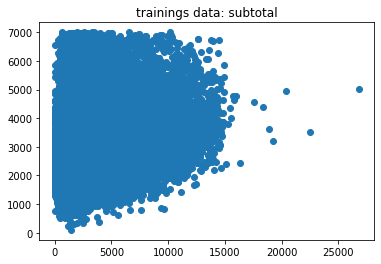

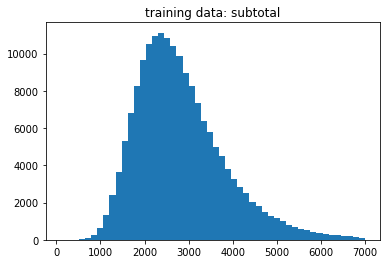

num_distinct_items


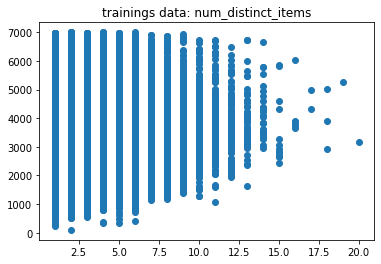

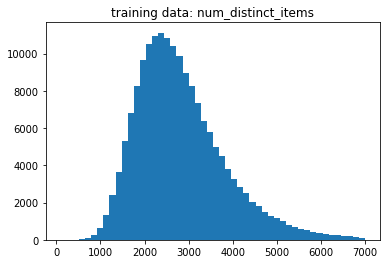

min_item_price


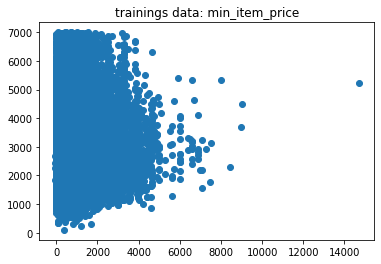

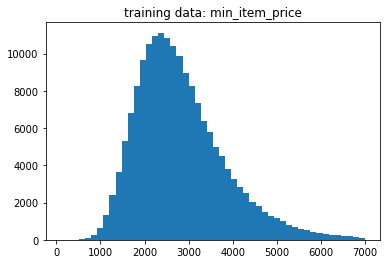

max_item_price


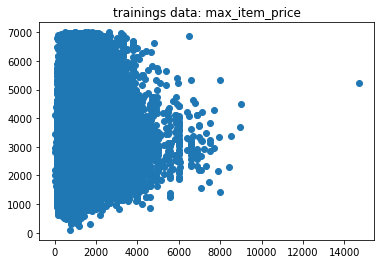

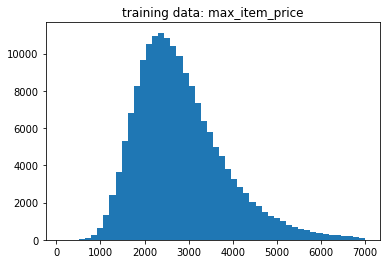

In [72]:
# inspect order features correlation with the total duration

features = ['subtotal', 'num_distinct_items', 'min_item_price', 
                  'max_item_price']

# for each order feature, plot total duration vs the feature
df_tmp = copy.deepcopy(training_fw.data)

for feature in features:
  print(feature)
  x = df_tmp[feature].values
  y = df_tmp['total_duration'].values
  plt.scatter(x, y)
  plt.title('trainings data: ' + feature)
  plt.show()
  plt.close()
  plt.hist(y, bins=50)
  plt.title('training data: ' + feature)
  plt.show()
  plt.close()

  

In [73]:
"""
observations: Based on the scatter plots and the histograms, I would expect the
scatter plot dots to fall along a line for these features to be correlated.
(The histogram validates the 'near'-normality of the data.)

Because these features do not influence the total duration time in a systematic 
way, they will not be included in the model

"""

"\nobservations: Based on the scatter plots and the histograms, I would expect the\nscatter plot dots to fall along a line for these features to be correlated.\n(The histogram validates the 'near'-normality of the data.)\n\nBecause these features do not influence the total duration time in a systematic \nway, they will not be included in the model\n\n"

8.2 apply fitted model to prediction data and save results

In [0]:
# get scaler from training framework and apply to prediction data set

scaler = training_fw.get_scaler()
df_tmp = predict_fw.data
df_tmp[selected_features]= scaler.transform(df_tmp[selected_features])

# 
model = training_fw.get_model()
predicted_duration = model.predict(df_tmp[selected_features])

In [0]:
# save predicted duration and delivery IDs in file with name 'data_to_predict.csv'

dict_ = dict(df_tmp)
dict_['predicted_duration'] = predicted_duration.flatten()
features = list(df_tmp.columns)

for feature in features:
  if feature not in ['predicted_duration', 'delivery_id']:
    dict_.pop(feature)

df_out = pd.DataFrame(data=dict_)
df_out.to_csv(path + 'data_to_predict.csv')

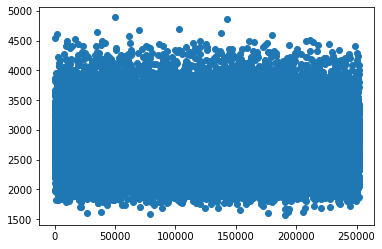

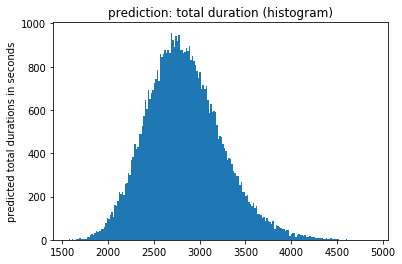

In [76]:
# plot results to check for unreasonable values
x = df_out['delivery_id']
y = df_out['predicted_duration']

plt.scatter(x, y)
plt.show()
plt.close()
plt.hist(y, bins=200)
plt.title('prediction: total duration (histogram)')
plt.ylabel('predicted total durations in seconds')
plt.savefig(path + 'total_duration_prediction_histogram.jpg', dpi=200)
plt.show()
plt.close()